## This is my attempt at implementing the RouBl algorithm

In [2]:
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tensorflow
# !pip install pandas
# !pip install torch
# !pip install tensorflow_probability
# !pip install tqdm
# !pip install tf_keras

In [3]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm

/Users/patrickgunn/Documents/Documents - iCloud Drive/Uni Fourth Year/Full Year/Group Project/Bayesian-Neural-Network-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_mean=0, prior_std=[0.1,0.1], alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define the prior parameters
        # prior_mean = torch.zeros(n)
        prior_mean = torch.randn(n) * prior_std[0] + prior_mean
        prior_cov_chol = torch.eye(n, **factory_kwargs) * prior_std[1]

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', prior_mean)
        self.register_buffer('prior_cov_chol', prior_cov_chol)
        self.register_buffer('prior_cov_inv', prior_cov_chol @ prior_cov_chol.t())

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = prior_mean
        self.cov_chol = prior_cov_chol

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_mean=0, prior_std=[0.1,0.1])
input_data = torch.tensor(([1.0], [1.5]), requires_grad=False)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)


### Regression Ground Truth & Dataset

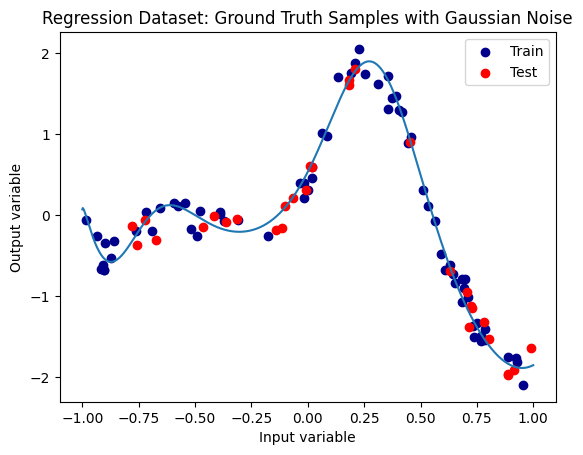

In [5]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Plot BNN Prior in Function Space

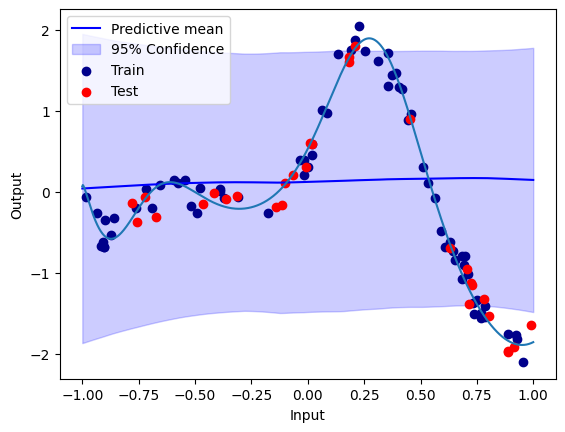

In [6]:
def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()
    plt.show()


BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_mean=0, prior_std=[0.7,0.5], alpha=1, gamma=0.01)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=200)

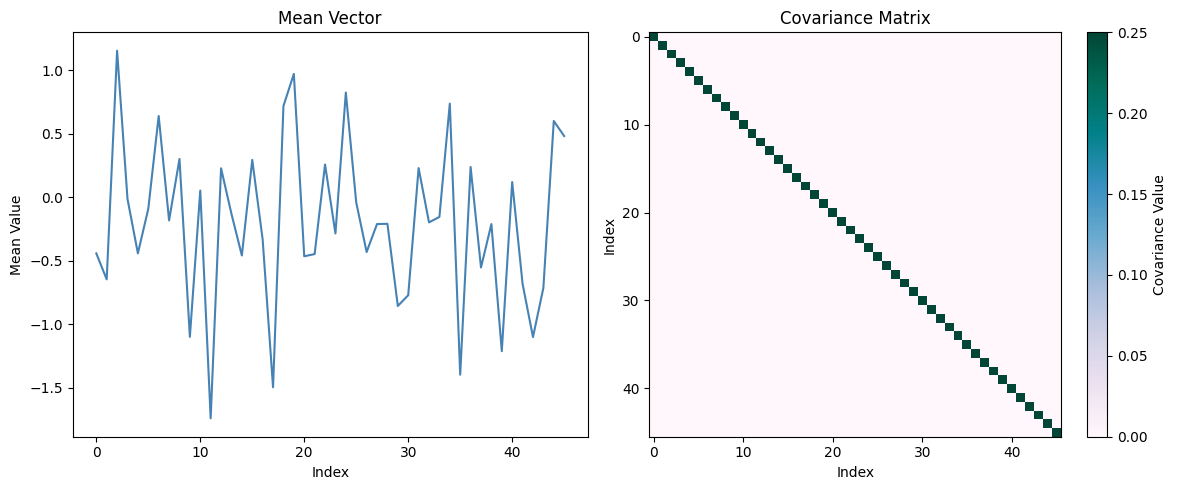

In [7]:
def plot_mean_and_covariance(BNN):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.mean)
    cov = to_numpy(BNN.cov_chol @ BNN.cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].plot(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN)


### Training

In [44]:
def compute_param_gradients(net, input, targets, noise, K):
    gradients = torch.zeros(net.num_params, requires_grad=False)
    for _ in range(K):
        sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        output = net.forward(input, sampled_params)  # Forward pass
        for i in range(output.shape[0]):
            output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True)  # Backpropagate to calculate gradients

        net_grads = sampled_params.grad
        g_k = net.gamma * net.prior_cov_inv @ (sampled_params - net.prior_mean) + net_grads
        gradients += g_k

    print(f'Max gradient is {torch.max(1/K * gradients.unsqueeze(1))}')
    # print('grads',(1/K * gradients.unsqueeze(1)))
    return 1/K * gradients.unsqueeze(1)


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)
# input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
# targets = torch.tensor(([2.0], [2.1]), requires_grad=False)

Epoch 1
Max gradient is 523.2533569335938
Epoch 2
Max gradient is 1176.169189453125
Epoch 3
Max gradient is 695.8984985351562
Epoch 4
Max gradient is 567.1497192382812
Epoch 5
Max gradient is 331.67626953125
Epoch 6
Max gradient is 316.7961120605469
Epoch 7
Max gradient is 586.6538696289062
Epoch 8
Max gradient is 338.4006652832031
Epoch 9
Max gradient is 551.7703247070312
Epoch 10
Max gradient is 195.26792907714844
Epoch 11
Max gradient is 273.7550048828125
Epoch 12
Max gradient is 389.2752380371094
Epoch 13
Max gradient is 318.2604675292969
Epoch 14
Max gradient is 363.28314208984375
Epoch 15
Max gradient is 174.83157348632812
Epoch 16
Max gradient is 231.72586059570312
Epoch 17
Max gradient is 383.45709228515625
Epoch 18
Max gradient is 262.4791564941406
Epoch 19
Max gradient is 171.52430725097656
Epoch 20
Max gradient is 192.14022827148438
Epoch 21
Max gradient is 260.5799560546875
Epoch 22
Max gradient is 210.6710662841797
Epoch 23
Max gradient is 158.17071533203125
Epoch 24
Max g

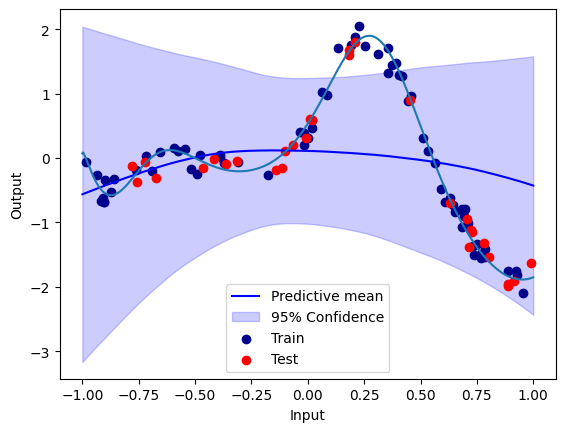

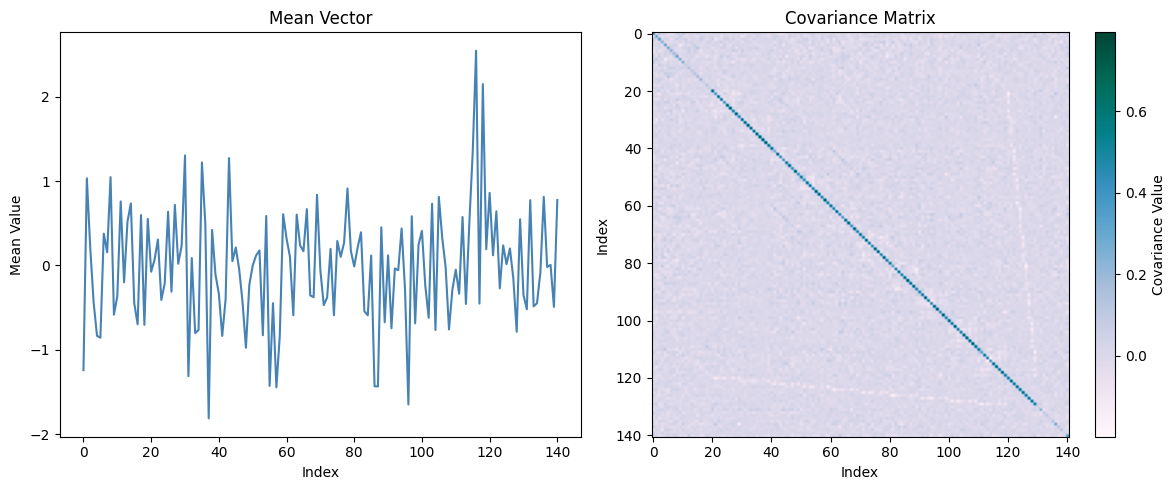

In [47]:
# Using sigma (not its chol), runs into errors computing chol at the end
def update_variational_params1(net, input, targets, noise=0.1, K=500):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    g_tp = g.t()

    with torch.no_grad():
        mu, sigma = net.mean.unsqueeze(1), net.cov_chol @ net.cov_chol.t()
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        
        sigma_tilde = 1 / (1 - alpha*gamma) * sigma
        v = sigma_tilde @ g 
        sigma = sigma_tilde - alpha / (1 + alpha * g_tp @ v) * v @ v.t()
        nu = g_tp @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha * (1 - nu) * g

    net.lambda_1 = lambda_1.flatten()
    net.mean = (sigma @ lambda_1).flatten()
    net.cov_chol = torch.linalg.cholesky(sigma, upper=False)


# Using rank-1 cholesky update algo
def update_variational_params2(net, input, targets, noise, K=100):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
        
    net.lambda_1 = lambda_1.flatten()
    net.mean = ((chol_new @ chol_new.t())@lambda_1).flatten()
    net.cov_chol = chol_new


def update_variational_params3(net, input, targets, noise, K=100):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    alpha = 0.01
    gamma = 1
    alpha_prime = torch.tensor([1 / (1-alpha*gamma)])

    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
    
        lambda_1 = net.lambda_1.unsqueeze(1)
        v = alpha_prime * chol @ (chol.t() @ g) # sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
    
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [n])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g

        net.lambda_1 = lambda_1.flatten()
        net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten()
        net.cov_chol = chol_updated 


BNN = FullCovGaussianNetwork(layer_sizes=[1, 10, 10, 1], prior_mean=0, prior_std=[.7,.7], alpha=0.001, gamma=0.0001)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 50
noise = 0.4

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params3(BNN, x_tr, y_tr, noise, K=100)
    if BNN.mean.isnan().any():
        print('Nans found')
        break

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=500)
plot_mean_and_covariance(BNN)

    


In [10]:
def update_variational_params_choldate(net, input, targets, noise=1, K=100):
    g = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    g_tp = g.t()

    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)

        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        v = alpha_prime * chol @ (chol.t() @ g) #sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [net.num_params])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = lambda_1.flatten()
    net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
    # print(net.mean)
    net.cov_chol = chol_updated # same here


In [11]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=[0.2,0.3], alpha=0.01, gamma=1)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


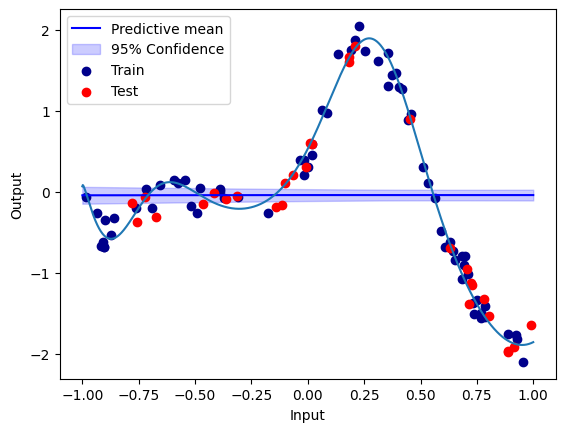

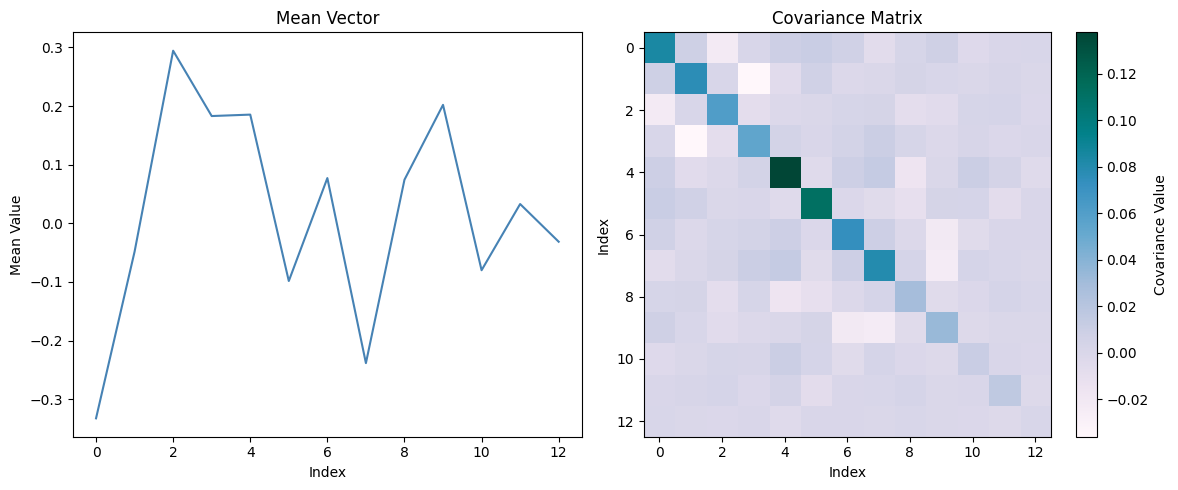

In [12]:

# BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.1,0.7], alpha=1, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 100
noise = 0.2

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, noise, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

plot_mean_and_covariance(BNN)

    


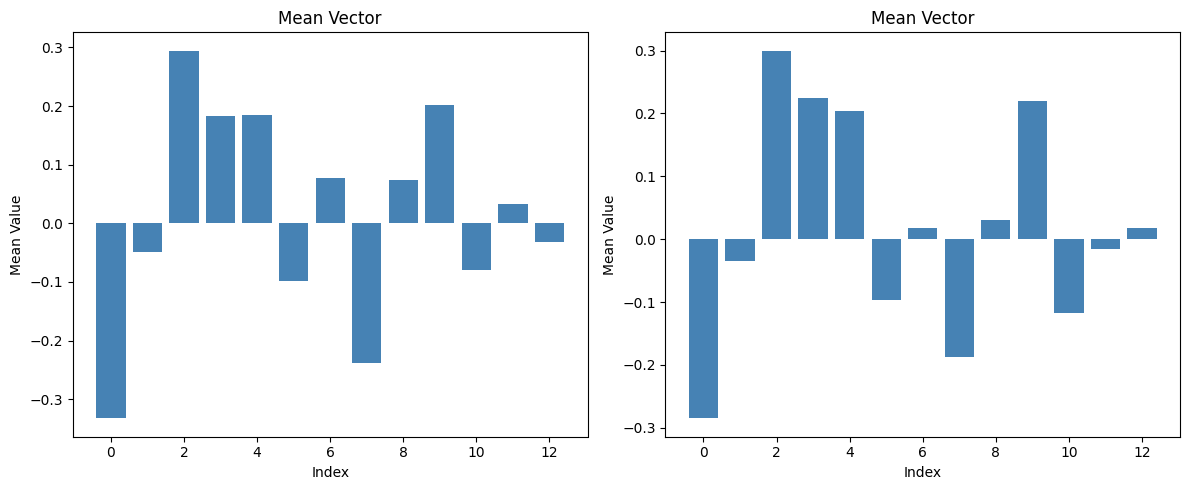

In [13]:
# Convert mean vector and covariance matrix to NumPy
mean = to_numpy(BNN.mean)
prior = to_numpy(BNN.prior_mean)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean vector as a bar plot
axs[0].bar(range(len(mean)), mean, color='steelblue')
axs[0].set_title("Mean Vector")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Mean Value")

# Plot mean vector as a bar plot
axs[1].bar(range(len(prior)), prior, color='steelblue')
axs[1].set_title("Mean Vector")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Mean Value")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [14]:
input_data = torch.tensor(([1.0]), requires_grad=False)
targets = torch.tensor(([2.0]), requires_grad=False)

In [15]:
compute_param_gradients(BNN, input_data, targets, noise = 0.15, K=1)

tensor([[  6.0856],
        [ 22.9429],
        [  6.0416],
        [ 22.9424],
        [ -0.7212],
        [ -0.5099],
        [ -6.6822],
        [ -5.2841],
        [ -3.2259],
        [-29.6145],
        [-14.8052],
        [-24.8401],
        [-88.8024]], grad_fn=<MulBackward0>)

In [16]:
input_data = torch.tensor(([1.0]), requires_grad=True)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters (13 in total)
params = torch.tensor([-0.8873,  0.0075, -0.1602, -0.8715,  0.8124,  1.0074,  0.2732,  0.8140,
         0.8655,  1.7433, -0.0403, -0.2616, -1.6349])

# Neural Network Structure
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_weight = nn.Parameter(params[0:2].view(2, 1))  # 2 weights (2x1 matrix)
        self.fc1_bias = nn.Parameter(params[2:4].view(2))       # 2 biases (vector)
        self.fc2_weight = nn.Parameter(params[4:8].view(2, 2))  # 4 weights (2x2 matrix)
        self.fc2_bias = nn.Parameter(params[8:10].view(2))      # 2 biases (vector)
        self.fc3_weight = nn.Parameter(params[10:12].view(1, 2))  # 2 weights (1x2 matrix)
        self.fc3_bias = nn.Parameter(params[12:13].view(1))       # 1 bias (scalar)

    def forward(self, x):
        # First Layer: Leaky ReLU activation
        x = F.linear(x, self.fc1_weight, self.fc1_bias)
        x = F.leaky_relu(x,negative_slope=0.1)
        
        # Second Layer: Leaky ReLU activation
        x = F.linear(x, self.fc2_weight, self.fc2_bias)
        x = F.leaky_relu(x,negative_slope=0.1)
        
        # Third Layer: Leaky ReLU activation
        x = F.linear(x, self.fc3_weight, self.fc3_bias)
        
        return x

# Initialize and test
model = CustomNN()
# for i in input_data:
#     output = model(i)
#     output.backward() 
    
output = model(input_data)
print("Output:", output)


Output: tensor([-2.0930], grad_fn=<ViewBackward0>)


In [18]:
# Forward pass
output = model(input_data)
params = params.unsqueeze(1)

# Backward pass to compute gradients
output.backward()

# Print gradients of model parameters
print("Gradients:")
print("fc1_weight:", model.fc1_weight.grad)
print("fc1_bias:", model.fc1_bias.grad)
print("fc2_weight:", model.fc2_weight.grad)
print("fc2_bias:", model.fc2_bias.grad)
print("fc3_weight:", model.fc3_weight.grad)
print("fc3_bias:", model.fc3_bias.grad)


Gradients:
fc1_weight: tensor([[-0.0104],
        [-0.0254]])
fc1_bias: tensor([-0.0104, -0.0254])
fc2_weight: tensor([[0.0042, 0.0035],
        [0.0274, 0.0226]])
fc2_bias: tensor([-0.0403, -0.2616])
fc3_weight: tensor([[0.6934, 1.6444]])
fc3_bias: tensor([1.])


In [19]:
df_dw = torch.tensor([[ 4.1062e-05],
        [-1.2082e-04],
        [ 4.1062e-05], [-1.2082e-04],
        [-3.6108e-06],[ -2.4226e-06],
        [-1.1431e-04], [-7.6692e-05],
        [0.0029], [0.0913],
        [-0.0034],  [0.2388],
        [1.]
        ])


In [20]:
g = -df_dw*(-(2-0.4283))/0.15**2 + 1/0.09*torch.eye(13)@params

In [21]:
g

tensor([[-9.8560],
        [ 0.0749],
        [-1.7771],
        [-9.6918],
        [ 9.0264],
        [11.1932],
        [ 3.0276],
        [ 9.0391],
        [ 9.8192],
        [25.7476],
        [-0.6853],
        [13.7743],
        [51.6878]])

In [22]:
my_g = torch.tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [23]:
my_g

tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [24]:
g.t()@(0.09*torch.eye(13))@g

tensor([[370.1749]])

In [25]:
((0.09*torch.eye(13))@g )@ (g.t()@(0.09*torch.eye(13)))

tensor([[ 7.8684e-01, -5.9790e-03,  1.4188e-01,  7.7373e-01, -7.2061e-01,
         -8.9359e-01, -2.4170e-01, -7.2162e-01, -7.8391e-01, -2.0555e+00,
          5.4708e-02, -1.0997e+00, -4.1264e+00],
        [-5.9790e-03,  4.5433e-05, -1.0781e-03, -5.8794e-03,  5.4758e-03,
          6.7902e-03,  1.8366e-03,  5.4835e-03,  5.9567e-03,  1.5619e-02,
         -4.1572e-04,  8.3560e-03,  3.1356e-02],
        [ 1.4188e-01, -1.0781e-03,  2.5581e-02,  1.3951e-01, -1.2993e-01,
         -1.6112e-01, -4.3581e-02, -1.3012e-01, -1.4135e-01, -3.7063e-01,
          9.8644e-03, -1.9828e-01, -7.4403e-01],
        [ 7.7373e-01, -5.8794e-03,  1.3951e-01,  7.6084e-01, -7.0860e-01,
         -8.7870e-01, -2.3767e-01, -7.0960e-01, -7.7084e-01, -2.0213e+00,
          5.3797e-02, -1.0813e+00, -4.0577e+00],
        [-7.2061e-01,  5.4758e-03, -1.2993e-01, -7.0860e-01,  6.5996e-01,
          8.1838e-01,  2.2136e-01,  6.6088e-01,  7.1792e-01,  1.8825e+00,
         -5.0103e-02,  1.0071e+00,  3.7791e+00],
        [-8.935

In [26]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 10, 10, 1], prior_std=[0.2,0.4], alpha=0.001, gamma=1)

In [27]:
def compute_param_gradients_testing(net, input, targets, noise, K=500):
    gradients = torch.zeros(net.num_params, requires_grad=False)
    for _ in range(K):
        sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
        # print('Params', sampled_params)
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        output = net.forward(input, sampled_params)  # Forward pass
        # print('output:',output)
        for i in range(output.shape[0]):
            output[i].backward(1/(noise**2) * (targets[i] - output[i]), retain_graph=True)  # Backpropagate to calculate gradients

        net_grads = sampled_params.grad
        # print('net_grads:',net_grads)
        g_k = -net_grads + net.gamma * net.prior_cov_inv @ (sampled_params - net.prior_mean) 
        gradients += g_k

    # print(f'Max gradient is {torch.max(1/K * gradients.unsqueeze(1))}')
    # print('grads',(1/K * gradients.unsqueeze(1)))
    return 1/K * gradients.unsqueeze(1)

In [28]:
compute_param_gradients_testing(BNN, input_data, targets, noise = 0.15, K=5000)

tensor([[ 1.3199e+01],
        [ 3.5877e+00],
        [ 9.5413e-02],
        [ 1.4278e+00],
        [ 9.3174e+00],
        [-2.2772e+00],
        [ 1.5895e+00],
        [ 6.5105e+00],
        [-2.8680e+00],
        [-3.1085e-01],
        [ 1.3198e+01],
        [ 3.5867e+00],
        [ 9.7328e-02],
        [ 1.4275e+00],
        [ 9.3162e+00],
        [-2.2758e+00],
        [ 1.5878e+00],
        [ 6.5122e+00],
        [-2.8678e+00],
        [-3.1040e-01],
        [-9.1637e-01],
        [-5.3189e-01],
        [-2.8990e-01],
        [-4.3390e-02],
        [-9.5752e-02],
        [-4.7303e-01],
        [-2.2061e-01],
        [-3.6107e-01],
        [-1.0714e+00],
        [-2.2831e-01],
        [ 6.8662e+00],
        [ 3.2635e+00],
        [ 2.1883e+00],
        [ 1.2433e+00],
        [ 3.9442e+00],
        [ 3.4759e+00],
        [ 1.2443e+00],
        [ 3.9537e+00],
        [ 4.9494e+00],
        [ 9.1637e-01],
        [ 7.3964e-01],
        [ 5.3799e-01],
        [ 4.0306e-01],
        [ 8

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters (13 in total)
params = torch.tensor([ 0.0938,  0.1414, -0.6012,  0.3518, -0.2040,  0.0450,  0.1655, -0.5710,
         0.3202,  0.2149,  0.2264,  0.1116, -0.1581],requires_grad=True)

# Neural Network Structure
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_weight = nn.Parameter(params[0:2].view(2, 1))  # 2 weights (2x1 matrix)
        self.fc1_bias = nn.Parameter(params[2:4].view(2))       # 2 biases (vector)
        self.fc2_weight = nn.Parameter(params[4:8].view(2, 2))  # 4 weights (2x2 matrix)
        self.fc2_bias = nn.Parameter(params[8:10].view(2))      # 2 biases (vector)
        self.fc3_weight = nn.Parameter(params[10:12].view(1, 2))  # 2 weights (1x2 matrix)
        self.fc3_bias = nn.Parameter(params[12:13].view(1))       # 1 bias (scalar)

    def forward(self, x):
        # First Layer: Leaky ReLU activation
        x = F.linear(x, self.fc1_weight, self.fc1_bias)
        x = F.leaky_relu(x)
        
        # Second Layer: Leaky ReLU activation
        x = F.linear(x, self.fc2_weight, self.fc2_bias)
        x = F.leaky_relu(x)
        
        # Third Layer: Leaky ReLU activation
        x = F.linear(x, self.fc3_weight, self.fc3_bias)
        
        return x

# Initialize and test
model = CustomNN()

    
output_2 = model(input_data)
print("Output:", output_2)
output_2.backward()  # Backpropagate to compute gradients

# Print gradients of parameters
for name, param in model.named_parameters():
    print(f"Gradient of {name}: {param.grad}")


Output: tensor([-0.0804], grad_fn=<ViewBackward0>)
Gradient of fc1_weight: tensor([[-0.0005],
        [ 0.0096]])
Gradient of fc1_bias: tensor([-0.0005,  0.0096])
Gradient of fc2_weight: tensor([[-1.1488e-03,  1.1166e-01],
        [-5.6626e-06,  5.5041e-04]])
Gradient of fc2_bias: tensor([0.2264, 0.0011])
Gradient of fc3_weight: tensor([[ 0.3434, -0.0007]])
Gradient of fc3_bias: tensor([1.])


In [30]:
sampled_params = BNN.sample_params()  # Sample from q distribution with gradient tracking

output = BNN.forward(input_data, sampled_params)  # Forward pass
print('output:',output)
output.backward(-1/(0.15**2) * (targets - output), retain_graph=True)
# output.backward()
print('Params', sampled_params)

net_grads = sampled_params.grad
print('net_grads:',net_grads)

output: tensor([-0.5292], grad_fn=<ViewBackward0>)
Params tensor([ 5.6862e-01,  4.7880e-01, -3.1979e-02, -5.6640e-01, -2.3124e-01,
         5.2245e-01, -1.7234e-02,  4.6513e-02, -4.5764e-01, -3.7803e-03,
         3.7088e-01, -3.1398e-01, -3.0841e-01,  3.0154e-01,  8.1788e-01,
        -2.9252e-02,  4.9820e-01,  5.0682e-01,  3.0433e-01, -3.4285e-01,
         2.7746e-01,  1.0025e-02,  3.0299e-01, -5.6291e-01,  1.4556e-01,
         5.4909e-01,  3.3722e-01,  2.0379e-01, -3.9075e-01,  6.9774e-01,
        -1.0519e-01, -1.6951e-01, -1.7206e-01, -3.8830e-01, -7.0880e-01,
        -1.1774e-01, -2.5405e-01,  4.0310e-01, -3.1180e-01, -3.5792e-01,
        -6.3029e-01,  6.1218e-01,  3.5431e-01, -6.7472e-01,  1.4146e-01,
         9.8167e-01,  4.4171e-01,  1.7577e-01, -1.9069e-01,  1.5219e-01,
         5.0030e-01,  3.5314e-02, -3.9832e-01, -4.6604e-01,  4.8492e-01,
         1.1491e-01,  9.4985e-02,  1.8386e-01, -2.2473e-01,  3.9749e-01,
         2.4067e-01, -1.2065e-01, -1.8916e-01,  9.7637e-02, -5.506

In [31]:
# Compute gradients (after calling output.backward())
all_grads = torch.cat([param.grad.view(-1) for param in model.parameters() if param.grad is not None])
print('net_grads:',all_grads*-1/(0.15**2) * (targets - output))


net_grads: tensor([ 5.1710e-02, -1.0736e+00,  5.1710e-02, -1.0736e+00,  1.2913e-01,
        -1.2552e+01,  6.3653e-04, -6.1872e-02, -2.5450e+01, -1.2545e-01,
        -3.8605e+01,  7.5941e-02, -1.1241e+02], grad_fn=<MulBackward0>)


In [32]:
# output.backward(-1/(0.15**2) * (targets - output), retain_graph=True)
BNN.prior_cov_inv.shape

torch.Size([141, 141])

In [33]:
def update_variational_params_testing(net, input, targets, noise=0.15, K=10):
    g = compute_param_gradients_testing(net, input, targets, noise, K) 
    print(g)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)

        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        v = alpha_prime * chol @ (chol.t() @ g) #sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [net.num_params])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = lambda_1.flatten()
    net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
    # print(net.mean)
    net.cov_chol = chol_updated # same here


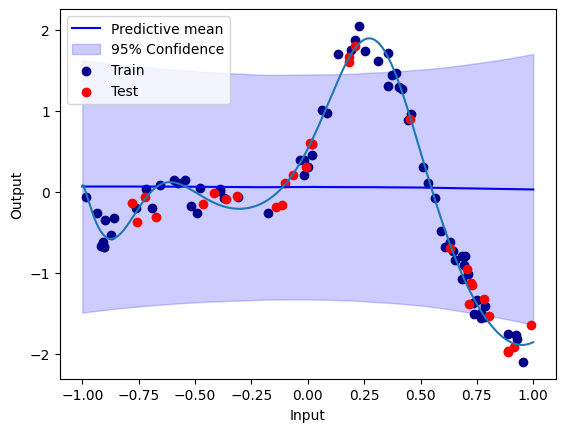

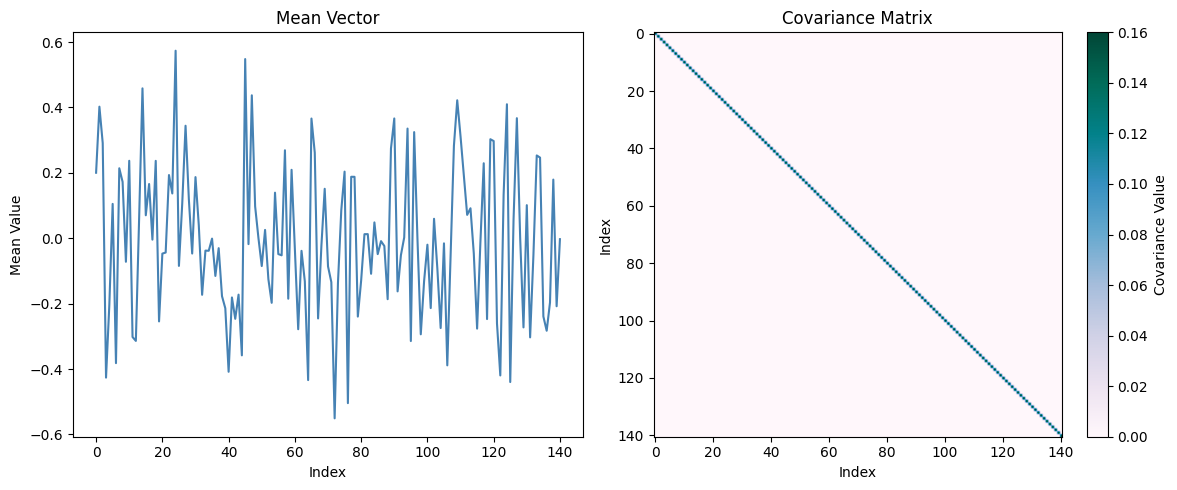

In [34]:
plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
plot_mean_and_covariance(BNN)

Epoch 1
tensor([[-38.2507],
        [-24.6748],
        [ 70.7851],
        [-39.1236],
        [-25.0709],
        [ 36.9766],
        [ -3.5783],
        [ 37.9872],
        [ 20.4342],
        [  8.1903],
        [242.8197],
        [  9.1843],
        [122.4712],
        [-58.2340],
        [216.2816],
        [ 87.3666],
        [178.4855],
        [126.0946],
        [101.8815],
        [ -8.8495],
        [140.3875],
        [ 65.7959],
        [ 54.7312],
        [108.1221],
        [321.4332],
        [154.2685],
        [114.8826],
        [104.4848],
        [135.5881],
        [ 54.0279],
        [ -2.8916],
        [-26.5042],
        [ 16.6004],
        [-14.7997],
        [ 29.7073],
        [-12.7742],
        [ -8.8611],
        [  2.3214],
        [ 40.1768],
        [ -5.6223],
        [  3.3102],
        [ -2.8934],
        [ -3.0031],
        [ -8.9926],
        [-10.0978],
        [  7.7238],
        [ -3.0041],
        [  2.3171],
        [ -4.3419],
        [ -1

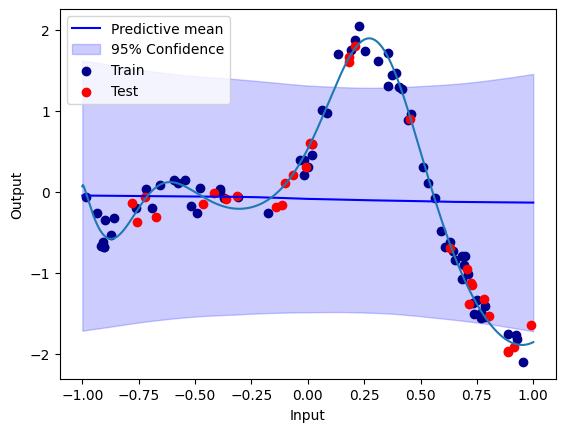

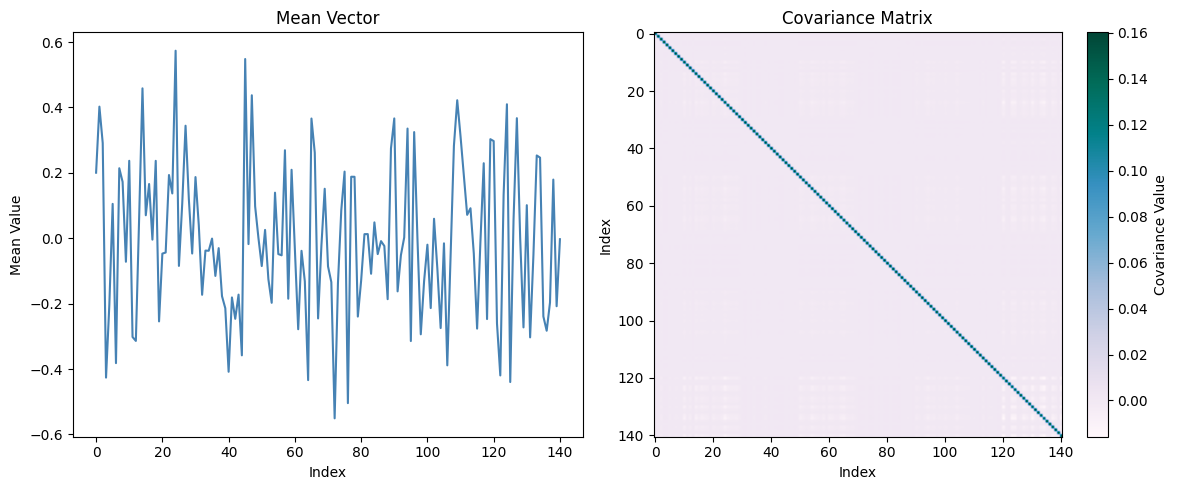

In [35]:
n_epochs = 1
noise = 0.15

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')
    update_variational_params_testing(BNN, x_tr, y_tr, noise, K=100)

# Plot results
plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
plot_mean_and_covariance(BNN)


In [36]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is accessible
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Current GPU index
print(torch.cuda.get_device_name(0))  # Name of the GPU


False
0


AssertionError: Torch not compiled with CUDA enabled

In [158]:
sampled_params = BNN.sample_params()  # Sample from q distribution with gradient tracking

output = BNN.forward(input_data, sampled_params)  # Forward pass
print('output:',output)


output: tensor([0.0749], grad_fn=<ViewBackward0>)
